<a href="https://colab.research.google.com/github/InsightofSPb/Automatic-word-processing-and-processing-of-images/blob/main/Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом задании мы рассмотрим работу UDpipe с двумя моделями:

предварительно обученной на SynTagRus https://universaldependencies.org/treebanks/ru_syntagrus/index.html \
обученной на Taiga https://universaldependencies.org/treebanks/ru_taiga/index.html \


# **Подключение необходимых модулей**

In [56]:
! pip install -q conllu
! pip install -q graphviz
! pip install -q ufal.udpipe
!wget -q 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-syntagrus-ud-2.5-191206.udpipe'
!wget -q 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-taiga-ud-2.5-191206.udpipe'


# Подключение библиотек

In [57]:
import sys
from conllu import parse  # парсер, создающий вложенный словарь
from graphviz import Digraph, Source  # для отрисовки деревьев
from ufal.udpipe import Model, Pipeline, ProcessingError  # UDPipe


# Загрузка модулей

In [58]:

# Скачиваем необходимые для дальнейшей работы материалы

# url1 = 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-syntagrus-ud-2.5-191206.udpipe'
# url2 = 'https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3131/russian-taiga-ud-2.5-191206.udpipe'



# Настройка работы с моделями

In [59]:

# Функция для загрузки моделей на основе текстов. Обучение
def loading():
    syntagrus_model_file = "russian-syntagrus-ud-2.5-191206.udpipe"  # корпус русского языка с человеческими правками
    taiga_model_file = 'russian-taiga-ud-2.5-191206.udpipe'  # набор текстов от Вышки, учитывающих то, чего нет в Syntagrus

    print("Loading model:" + syntagrus_model_file)
    syntagrus_model = Model.load(syntagrus_model_file)
    print("Loading done")

    print("Loading model:" + taiga_model_file)
    taiga_model = Model.load(taiga_model_file)
    print("Loading done")
    return syntagrus_model, taiga_model


syn, taig = loading()

Loading model:russian-syntagrus-ud-2.5-191206.udpipe
Loading done
Loading model:russian-taiga-ud-2.5-191206.udpipe
Loading done


# Построение цепочки обработки
Строим цепочку обработки -- от сырого текста до синтаксического дерева

In [60]:
input_format = "tokenize"
output_format = "conllu"

# Pipeline(given model, input, tagger, parser, output)
# In general, pipeline - a sequence of data processing mechanisms
# Применяем обработку к сырому тексту
syntag_pipeline = Pipeline(syn, input_format, Pipeline.DEFAULT, Pipeline.DEFAULT, output_format)
taiga_pipeline = Pipeline(taig, input_format, Pipeline.DEFAULT, Pipeline.DEFAULT, output_format)

error = ProcessingError()

Применение собственно цепочки обработки к сырому тексту; вывод в формате CoNLL-U.

In [61]:
# Применяем цепочки обработки к сырому тексту. Первая переменная - предложение, второя - цепочка обработки
def parse_syntax(raw_text, pipeline):
    """ Applying UDPipe """
    text = raw_text.strip()  # убираем лишние пробелы
    processed = pipeline.process(text, error)
    # Process the given input stream, writing results to the given output stream. If the processing succeeded, true
    # is returned; otherwise, false is returned with an error stored in the error argument.
    if error.occurred():
        sys.stderr.write("An error occurred when running run_udpipe: ")  # сообщение об ошибках
        sys.stderr.write(error.message)
        sys.stderr.write("\n")
    return processed


# Проводим разбор предложений
syntag = parse_syntax("Сегодня даже численность населения этого государства является относительной величиной .", syntag_pipeline)
taiga = parse_syntax("Сегодня даже численность населения этого государства является относительной величиной .", taiga_pipeline)


# **Графововое представление дерева разбора**
Методами библиотеки `conllu` превращаем выданный нам udpipe разбор в формате CoNLL-U в дерево, с которым удобно работать.

С помощью стандартного обхода в ширину наполняем рёбрами объект `Digraph` для последующей визуализации дерева с помощью `graphviz`.

In [62]:
def parse_output(conll):
    sentences = parse(conll)
    return [s.to_tree() for s in sentences]  # to.tree() - turning TokenList to TokenTree



Реализовывается алгоритм обхода по ширине.
С помощью конструктора задаётся элемент `(0)` в дереве, он же добавляется в очередь `queue`. Дальше идёт цикл: элемент из очереди удаляется, но записывается в переменную, и он красиво оформляется (см. любой лепесток). При этом у каждого такого элемента (объекта класса) есть атрибут `children` - дети. Список этих детей получается ещё при парсинге в `parse_output`. Для каждого такого ребёнка красивое оформление предусмотрено 2-м циклом. \
У нас снова в очереди есть элемент - `Порвались`. С ним проделываем то же самое - возвращаем, удаляя из очереди, но в очередь пишем его детей. Их также оформляем. Алгоритм работает, пока не дойдём донизу дерева, где уже нет детей

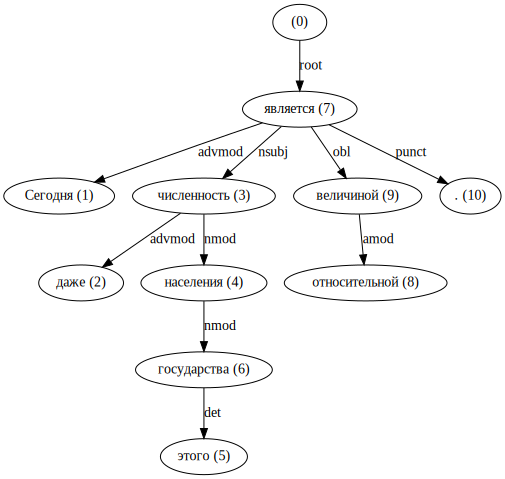

In [72]:
class Root(object):
    def __init__(self, child):
        self.token = {"form": "", "id": 0, "deprel": "root"}
        self.children = [child]


def draw_tree(tree):
    g = Digraph(format='png')  # node - лепесток, edge - ветка

    queue = [Root(tree)]  # очередь по типу FIFO, для обхода по дереву

    while len(queue) > 0:  # реализация алгоритма обхода в ширину

        head = queue.pop()  # возвращает последний элемент, удаляя его при этом
        head_label = head.token["form"] + " (%d)" % head.token["id"]  #надпись
        # на лепестке - само слово + его номер
        queue.extend(head.children)

        for c in head.children:
            c_label = c.token["form"] + " (%d)" % c.token["id"]
            g.edge(head_label, c_label, label=c.token["deprel"])  # часть речи
            # между двумя лепестками

    return g


str_tree = parse_output(syntag.strip())[0]  # применяем парсер к предложению
taiga_tree = parse_output(taiga.strip())[0]
draw_tree(str_tree)  # рисуем дерево


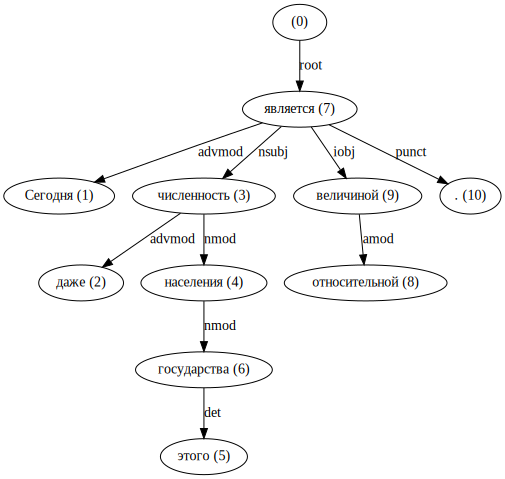

In [71]:
draw_tree(taiga_tree)

# Вычисление LAS и UAS
Для этого набираем множества всех рёбер с метками и без и смотрим на размеры пересечений.

In [68]:
def edges_sets(tree):
    """ Reading edges encoded as strings """

    edges_labeled = []
    edges_unlabeled = []
    queue = [Root(tree)]

    while len(queue) > 0:
        head = queue.pop()
        head_label = head.token["form"] + " (%d)" % head.token["id"]
        queue.extend(head.children)

        for c in head.children:
            c_label = c.token["form"] + " (%d)" % c.token["id"]
            edges_unlabeled.append((head_label, c_label))
            edges_labeled.append((head_label, c_label, c.token["deprel"]))

    return set(edges_labeled), set(edges_unlabeled)

def accuracy(gold, pred):
  gold_labeled, gold_unlabeled = edges_sets(gold)
  pred_labeled, pred_unlabeled = edges_sets(pred)

  return len(gold_labeled.intersection(pred_labeled)) / len(gold_labeled),\
         len(gold_unlabeled.intersection(pred_unlabeled)) / len(gold_unlabeled)


LAS, UAS = accuracy(str_tree, taiga_tree)
"LAS: %.4f UAS: %.4f" % (LAS, UAS)

'LAS: 0.9000 UAS: 1.0000'

# Вычисление глубины дерева
Вычислим глубину дерева, например, для разбора модели taiga (ребро root не учитывается).
Для этого также можно использовать, например, обход в ширину.

In [70]:
t = []
for i in range(2):
    depth = 0
    if i == 0:
        queue = [(taiga_tree, depth)]
        while len(queue) > 0:
            head, depth = queue.pop(0)
            queue.extend([(c, depth + 1) for c in head.children])
    if i == 1:
        queue = [(str_tree, depth)]
        while len(queue) > 0:
            head, depth = queue.pop(0)
            queue.extend([(c, depth + 1) for c in head.children])
    t.append(depth)
print("Глубина дерева: ", max(t))

Глубина дерева:  4
